In [1]:
%matplotlib inline

In [39]:
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

pd.options.display.float_format = '{:,.4f}'.format

import matplotlib.pyplot as plt

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
df = pd.read_csv('Data for Forecast.csv', decimal=",")
df.head()

,Year,Month,Sales
0,2009,1,44265939.13
1,2009,3,54900710.11
2,2009,2,55917784.58
3,2009,4,59119663.88
4,2009,5,60949016.31


In [5]:
df['Date'] = pd.period_range(start='2009-01', end='2019-12', freq='M')
df.index = df['Date']
df = df.drop(['Year', 'Month', 'Date'], axis=1)
df.head()

,Sales
Date,
2009-01,44265939.13
2009-02,54900710.11
2009-03,55917784.58
2009-04,59119663.88
2009-05,60949016.31


In [6]:
df.Sales = df.Sales.astype('float64') 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 132 entries, 2009-01 to 2019-12
Freq: M
Data columns (total 1 columns):
Sales    132 non-null float64
dtypes: float64(1)
memory usage: 2.1 KB


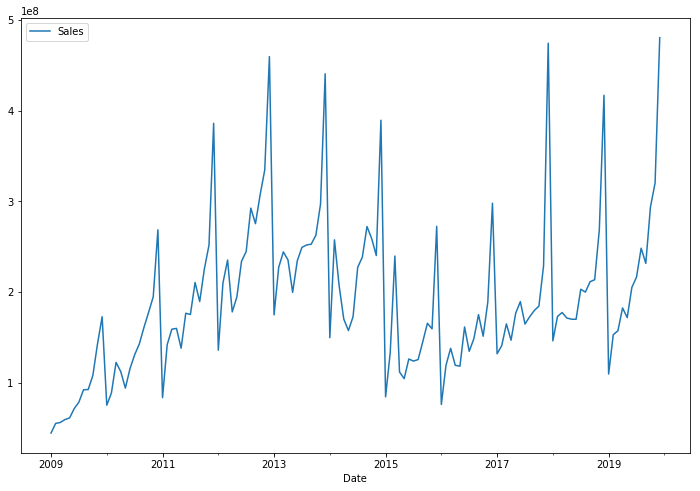

In [8]:
df.plot(figsize=(12,8));

Критерий Дики-Фуллера: p=0.243565


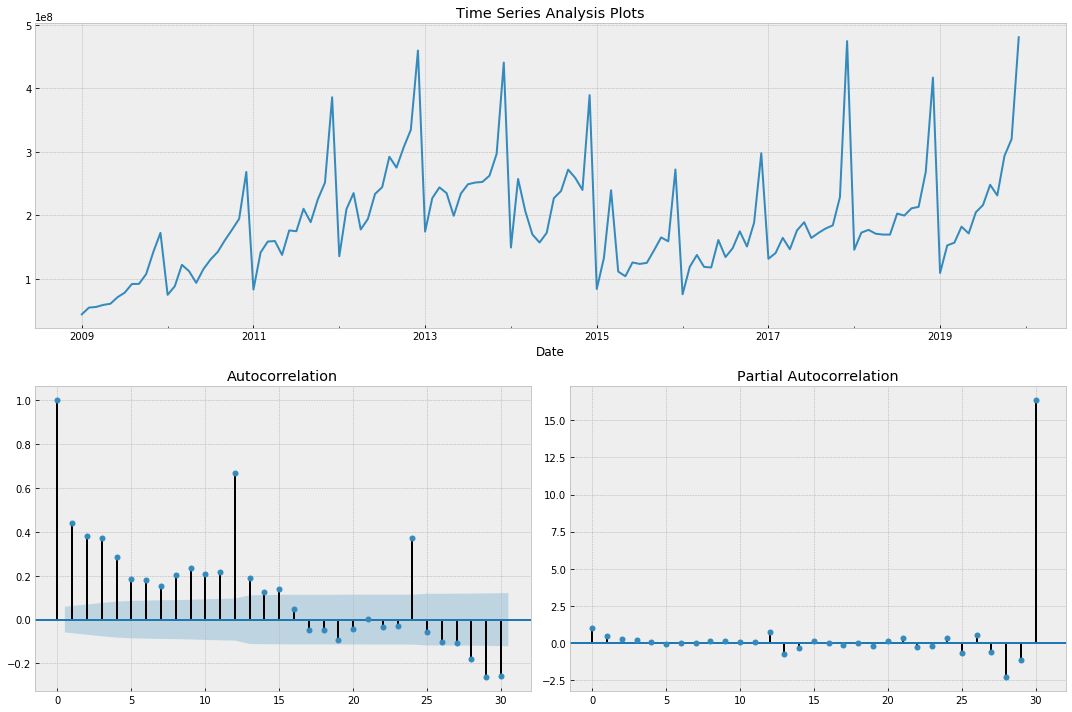

In [10]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(df.Sales, lags=30)

Критерий Дики-Фуллера: p=0.164503
Оптимальный параметр преобразования Бокса-Кокса: 0.268259


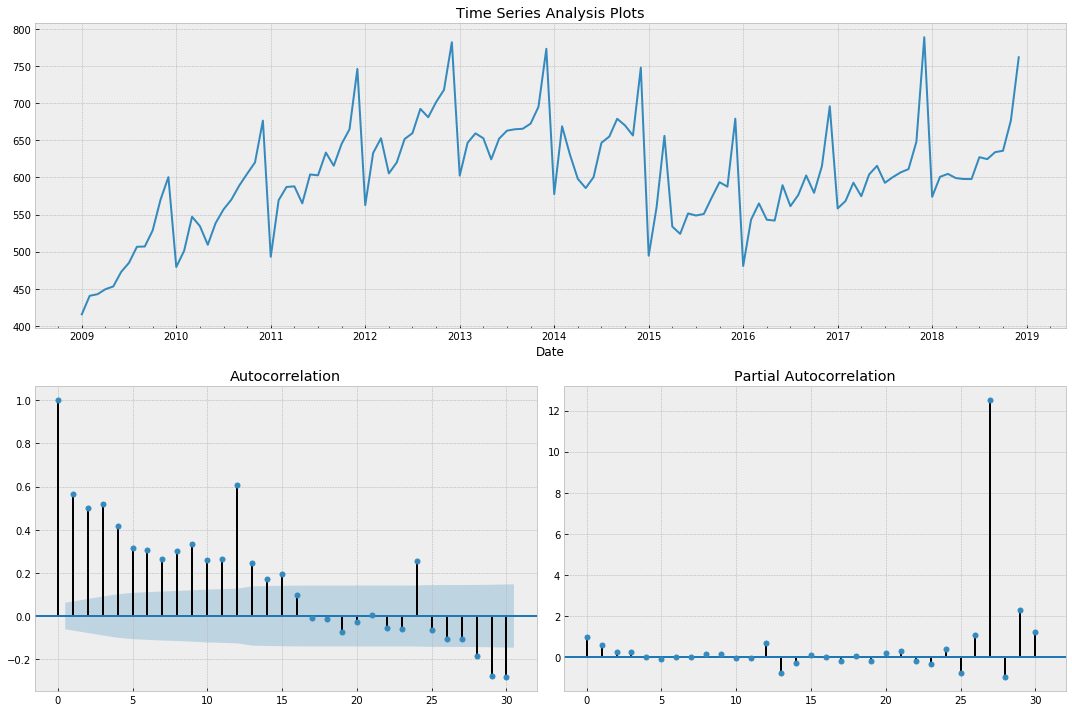

In [24]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y)/lmbda))

data = df[:120]
data['Sales_box'], lmbda = scs.boxcox(data.Sales)
tsplot(data.Sales_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

In [25]:
data.tail()

,Sales,Sales_box
Date,,
2018-08,199774030.8,624.528615
2018-09,211153607.5,633.935012
2018-10,213467878.0,635.802364
2018-11,268761114.0,676.565163
2018-12,416942634.5,761.614164


Критерий Дики-Фуллера: p=0.420021


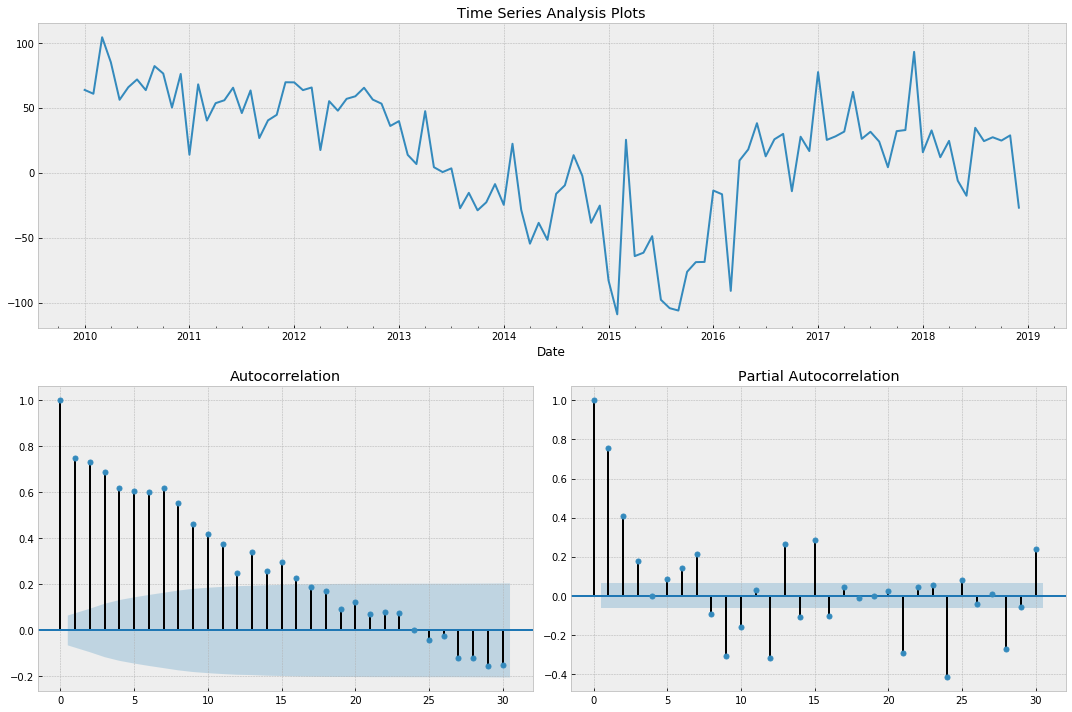

In [26]:
data['Sales_box_season'] = data.Sales_box - data.Sales_box.shift(12)
tsplot(data.Sales_box_season[12:], lags=30)

Критерий Дики-Фуллера: p=0.031898


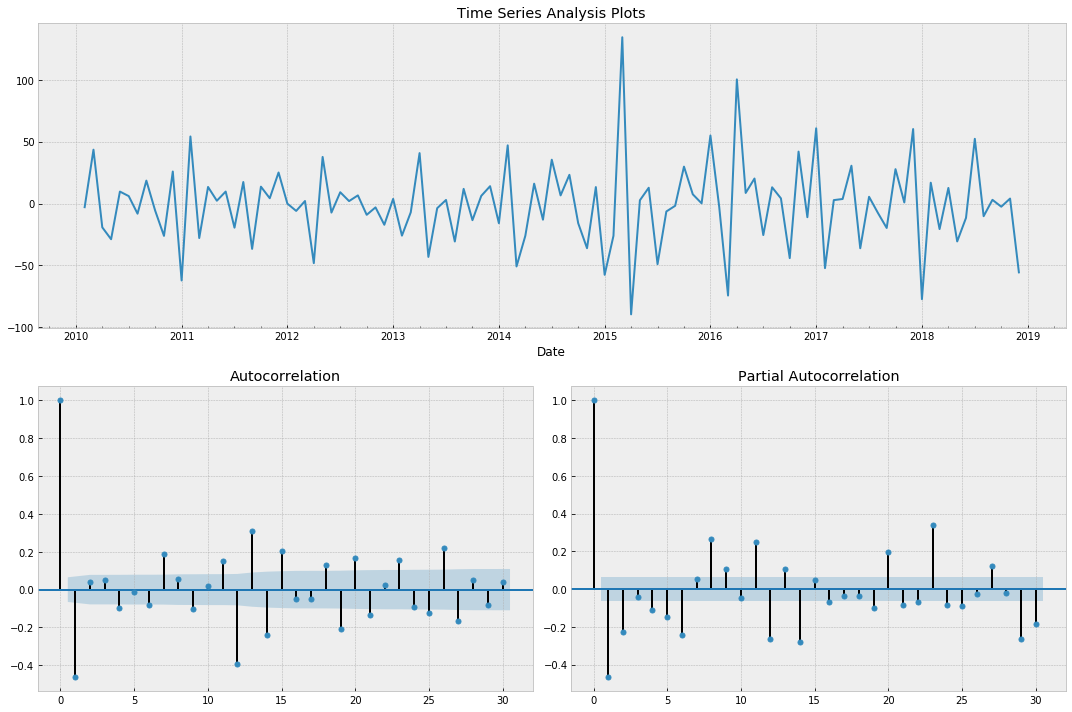

In [27]:
data['Sales_box_season_diff'] = data.Sales_box_season - data.Sales_box_season.shift(1)
tsplot(data.Sales_box_season_diff[12+1:], lags=30)

In [28]:
test = sm.tsa.adfuller(data.Sales_box_season_diff[12+1:])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')


adf:  -3.033320426053438
p-value:  0.0318976974416257
Critical values:  {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}
единичных корней нет, ряд стационарен


Наконец, получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, не забыв, что предварительно уже сделали первые и сезонные разности.

In [33]:
ps = range(0, 6)
d=2
qs = range(0, 5)
Ps = range(0, 6)
D=2
Qs = range(0, 2)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

360

In [34]:
%%time
results = []
best_aic = float("inf")

for param in log_progress(parameters_list, every=5):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=False)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: Con

C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: Con

C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: Con

C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: Con

      parameters         aic
32  (0, 2, 4, 0)  940.406438
34  (0, 2, 5, 0)  941.765183
33  (0, 2, 4, 1)  941.810998
92  (1, 2, 4, 0)  942.364514
44  (0, 3, 4, 0)  942.368742
Wall time: 1h 19min 53s


In [35]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.Sales_box, order=(0, d, 2), 
                                        seasonal_order=(4, D, 0, 12)).fit(disp=False)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Sales_box   No. Observations:                  120
Model:             SARIMAX(0, 2, 2)x(4, 2, 0, 12)   Log Likelihood                -463.203
Date:                            Wed, 22 Jan 2020   AIC                            940.406
Time:                                    01:47:49   BIC                            958.210
Sample:                                01-31-2009   HQIC                           947.598
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5933      1.784     -0.893      0.372      -5.089       1.903
ma.L2          0.5939      1.042   

Критерий Дики-Фуллера: p=0.000000


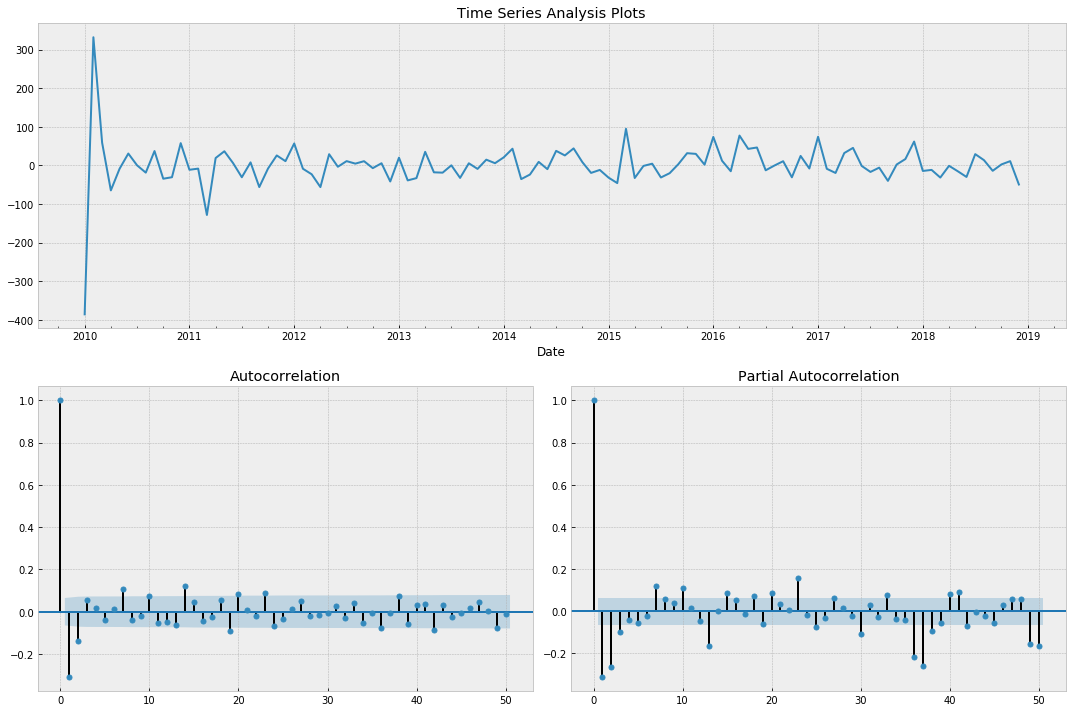

In [36]:
tsplot(best_model.resid[12:], lags=50)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


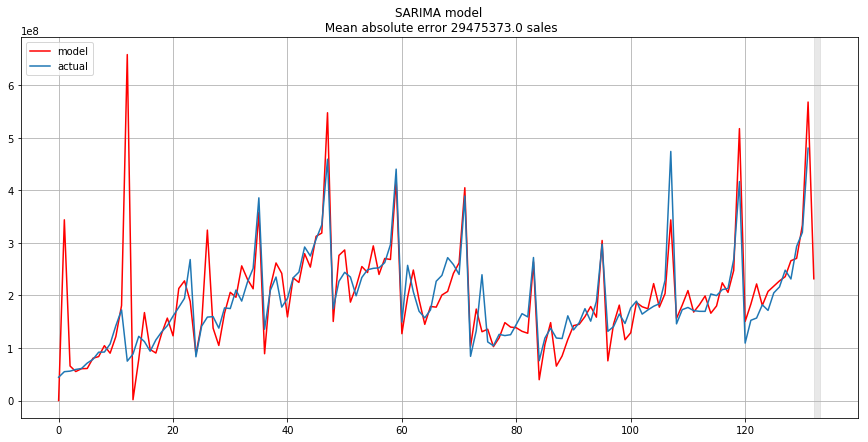

In [37]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+12), lmbda)
forecast = data.arima_model.append(forecast).values
actual = df.Sales.values
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} sales".format(round(mean_absolute_error(data.dropna().Sales, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [41]:
data.tail(24)

,Sales,Sales_box,Sales_box_season,Sales_box_season_diff,arima_model
Date,,,,,
2017-01,"131,735,736.0000",558.1298,77.4159,60.8145,"75,534,648.3876"
2017-02,"140,752,176.4000",568.1973,25.1917,-52.2242,"145,526,794.6463"
2017-03,"164,698,330.6000",592.8176,27.9463,2.7546,"181,678,527.5960"
2017-04,"146,708,334.1000",574.5915,31.6031,3.6568,"115,721,039.0271"
2017-05,"176,470,640.0000",603.9687,62.1548,30.5517,"128,966,822.9108"
2017-06,"189,281,378.8000",615.5013,26.0125,-36.1423,"186,759,239.7449"
2017-07,"164,530,262.4000",592.6542,31.4525,5.4400,"178,575,216.1199"
2017-08,"172,492,036.7000",600.2627,23.9206,-7.5319,"174,753,427.4203"
2017-09,"179,425,247.9000",606.6816,4.1593,-19.7614,"222,661,440.0347"


In [42]:
df.describe()

,Sales
count,132.0000
mean,"190,722,379.1988"
std,"85,467,561.1324"
min,"44,265,939.1300"
25%,"137,215,285.2000"
50%,"174,771,993.1000"
75%,"235,165,491.1500"
max,"480,480,288.9900"
